In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import genetools
from covid_serology import config
from numpy.testing import assert_array_equal

# Load data

In [2]:
# patients have multiple timepoints
infection_df = pd.read_csv(f"{config.paths.data_dir}/infection_cohort2.coronavirus.csv")
infection_df

,sample_id,timepoint,days_post_pcr,Wuhan_S_ECL,Wuhan_S_AU,NL63_S_ECL,NL63_S_AU,Wuhan_N_ECL,Wuhan_N_AU,CoV_S_ECL,...,Wuhan_NTD_ECL,Wuhan_NTD_AU,HKU1_S_ECL,HKU1_S_AU,OC43_S_ECL,OC43_S_AU,h229E_S_ECL,h229E_S_AU,Wuhan_RBD_ECL,Wuhan_RBD_AU
0,cohort2-0018,4,228,86046,20448.985100,3909,1026.073636,61224,19838.230620,10723,...,21046,445.893700,42968,12394.092590,124421,36897.87151,112970,33507.237730,30666,8551.874965
1,cohort2-0019,3,85,17829,4165.074134,7698,2082.749652,26575,8558.801862,6954,...,1928,38.988191,30524,8795.139084,107480,31657.89086,228485,68959.972520,7958,2150.836428
2,cohort2-0024,3,90,19952,4668.057857,18979,5298.502667,33690,10871.043580,8618,...,4668,96.978479,38054,10972.882570,288186,88122.43342,218524,65881.365110,6300,1691.170377
3,cohort2-0024,4,237,13423,3122.820965,14328,3963.776070,5694,1795.757465,5790,...,3163,65.094749,25717,7404.093274,186010,56059.22264,138372,41249.063770,5033,1341.339845
4,cohort2-0026,2,34,160776,38423.648820,6372,1710.887541,185053,60349.984360,4744,...,26382,559.964120,90824,26300.968450,99667,29246.80938,24323,6929.655205,44085,12383.055390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,cohort2-OHC003,3,79,49202,12972.885750,14857,5078.202527,53622,17801.280860,4340,...,16469,502.901725,140101,42909.134700,564954,206565.73420,127880,41646.722360,6562,2282.053117
83,cohort2-OHC007,3,85,89009,23351.945650,6693,2211.698953,132530,44242.279170,3520,...,18741,572.007232,23858,7115.751402,100316,36228.16822,136463,44517.826380,20957,7513.068412
84,cohort2-OHC007,4,219,41850,11048.327810,6451,2128.033345,26937,8897.868997,3119,...,9110,278.524530,21222,6311.959586,92653,33413.21566,132834,43303.305200,11280,3982.895095
85,cohort2-OHC010,3,97,283,51.541600,16929,5815.622154,384,98.577705,176,...,363,9.413986,16952,5011.368452,195940,71326.66431,53346,16971.958980,838,259.715337


In [3]:
infection_participants = pd.read_csv(
    f"{config.paths.data_dir}/infection_cohort2.demographics.csv"
)
infection_participants

,Record.ID,Status
0,cohort2-0018,Mild
1,cohort2-0019,Mild
2,cohort2-0024,Mild
3,cohort2-0026,Mild
4,cohort2-0029,Mild
...,...,...
69,cohort2-0222,Mild
70,cohort2-OHC001,Mild
71,cohort2-OHC003,Mild
72,cohort2-OHC007,Mild


In [4]:
# one row per patient in demographics table
assert all(infection_participants["Record.ID"].value_counts() == 1)

In [5]:
infection_participants.columns

Index(['Record.ID', 'Status'], dtype='object')

# infection data reshape

In [6]:
infection_df.columns

Index(['sample_id', 'timepoint', 'days_post_pcr', 'Wuhan_S_ECL', 'Wuhan_S_AU',
       'NL63_S_ECL', 'NL63_S_AU', 'Wuhan_N_ECL', 'Wuhan_N_AU', 'CoV_S_ECL',
       'CoV_S_AU', 'Wuhan_NTD_ECL', 'Wuhan_NTD_AU', 'HKU1_S_ECL', 'HKU1_S_AU',
       'OC43_S_ECL', 'OC43_S_AU', 'h229E_S_ECL', 'h229E_S_AU', 'Wuhan_RBD_ECL',
       'Wuhan_RBD_AU'],
      dtype='object')

In [7]:
# only one sample per patient per timepoint
assert all(infection_df.groupby(["sample_id", "timepoint"]).size() == 1)

In [8]:
# how many total samples per patient? many have only a single sample:
infection_df["sample_id"].value_counts().value_counts()

1    62
2    11
3     1
Name: sample_id, dtype: int64

In [9]:
infection_df = pd.melt(
    infection_df,
    id_vars=["sample_id", "timepoint", "days_post_pcr"],
    var_name="measurement",
)
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value
0,cohort2-0018,4,228,Wuhan_S_ECL,86046.000000
1,cohort2-0019,3,85,Wuhan_S_ECL,17829.000000
2,cohort2-0024,3,90,Wuhan_S_ECL,19952.000000
3,cohort2-0024,4,237,Wuhan_S_ECL,13423.000000
4,cohort2-0026,2,34,Wuhan_S_ECL,160776.000000
...,...,...,...,...,...
1561,cohort2-OHC003,3,79,Wuhan_RBD_AU,2282.053117
1562,cohort2-OHC007,3,85,Wuhan_RBD_AU,7513.068412
1563,cohort2-OHC007,4,219,Wuhan_RBD_AU,3982.895095
1564,cohort2-OHC010,3,97,Wuhan_RBD_AU,259.715337


In [10]:
# just in case, convert to float and switch non-numeric values to nan
infection_df["value"] = pd.to_numeric(infection_df["value"], errors="coerce")
infection_df.dtypes

sample_id         object
timepoint          int64
days_post_pcr      int64
measurement       object
value            float64
dtype: object

In [11]:
infection_df["value"].isna().value_counts()

False    1566
Name: value, dtype: int64

In [12]:
infection_df[infection_df["value"].isna()]

,sample_id,timepoint,days_post_pcr,measurement,value


In [13]:
infection_df["measurement"].unique()

array(['Wuhan_S_ECL', 'Wuhan_S_AU', 'NL63_S_ECL', 'NL63_S_AU',
       'Wuhan_N_ECL', 'Wuhan_N_AU', 'CoV_S_ECL', 'CoV_S_AU',
       'Wuhan_NTD_ECL', 'Wuhan_NTD_AU', 'HKU1_S_ECL', 'HKU1_S_AU',
       'OC43_S_ECL', 'OC43_S_AU', 'h229E_S_ECL', 'h229E_S_AU',
       'Wuhan_RBD_ECL', 'Wuhan_RBD_AU'], dtype=object)

In [14]:
infection_df = infection_df[infection_df["measurement"].str.contains("AU")].copy()
infection_df["measurement"].value_counts()

NL63_S_AU       87
OC43_S_AU       87
Wuhan_S_AU      87
Wuhan_RBD_AU    87
HKU1_S_AU       87
h229E_S_AU      87
Wuhan_NTD_AU    87
CoV_S_AU        87
Wuhan_N_AU      87
Name: measurement, dtype: int64

In [15]:
infection_df["measurement"] = infection_df["measurement"].str.replace("_AU", "")
infection_df["measurement"].value_counts()

h229E_S      87
OC43_S       87
Wuhan_N      87
Wuhan_RBD    87
CoV_S        87
Wuhan_NTD    87
HKU1_S       87
Wuhan_S      87
NL63_S       87
Name: measurement, dtype: int64

In [16]:
# extract parts of measurement column
# all coronavirus plate measurements are IgG only
measurement_parts = (
    infection_df["measurement"]
    .str.split("_", expand=True)
    .rename(columns={0: "virus", 1: "target"})
    .assign(variant_plate_type="Wuhan", antibody="IgG")
    .apply(lambda col: col.str.strip())
)
measurement_parts

,virus,target,variant_plate_type,antibody
87,Wuhan,S,Wuhan,IgG
88,Wuhan,S,Wuhan,IgG
89,Wuhan,S,Wuhan,IgG
90,Wuhan,S,Wuhan,IgG
91,Wuhan,S,Wuhan,IgG
...,...,...,...,...
1561,Wuhan,RBD,Wuhan,IgG
1562,Wuhan,RBD,Wuhan,IgG
1563,Wuhan,RBD,Wuhan,IgG
1564,Wuhan,RBD,Wuhan,IgG


In [17]:
measurement_parts["virus"].value_counts()

Wuhan    348
h229E     87
OC43      87
CoV       87
NL63      87
HKU1      87
Name: virus, dtype: int64

In [18]:
measurement_parts["target"].value_counts()

S      522
N       87
RBD     87
NTD     87
Name: target, dtype: int64

In [19]:
measurement_parts["antibody"].value_counts()

IgG    783
Name: antibody, dtype: int64

In [20]:
measurement_parts["variant_plate_type"].value_counts()

Wuhan    783
Name: variant_plate_type, dtype: int64

In [21]:
infection_df = pd.concat([infection_df, measurement_parts], axis=1)
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value,virus,target,variant_plate_type,antibody
87,cohort2-0018,4,228,Wuhan_S,20448.985100,Wuhan,S,Wuhan,IgG
88,cohort2-0019,3,85,Wuhan_S,4165.074134,Wuhan,S,Wuhan,IgG
89,cohort2-0024,3,90,Wuhan_S,4668.057857,Wuhan,S,Wuhan,IgG
90,cohort2-0024,4,237,Wuhan_S,3122.820965,Wuhan,S,Wuhan,IgG
91,cohort2-0026,2,34,Wuhan_S,38423.648820,Wuhan,S,Wuhan,IgG
...,...,...,...,...,...,...,...,...,...
1561,cohort2-OHC003,3,79,Wuhan_RBD,2282.053117,Wuhan,RBD,Wuhan,IgG
1562,cohort2-OHC007,3,85,Wuhan_RBD,7513.068412,Wuhan,RBD,Wuhan,IgG
1563,cohort2-OHC007,4,219,Wuhan_RBD,3982.895095,Wuhan,RBD,Wuhan,IgG
1564,cohort2-OHC010,3,97,Wuhan_RBD,259.715337,Wuhan,RBD,Wuhan,IgG


<AxesSubplot:>

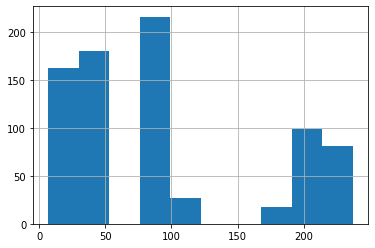

In [22]:
infection_df["days_post_pcr"].hist()

In [23]:
infection_df["timepoint"].value_counts()

3    243
2    207
4    198
1    135
Name: timepoint, dtype: int64

In [24]:
# timepoint label map
map_infection_to_global_timepoint_labels = {
    1: "day 21 / weeks 2&3",
    2: "day 28 / week 4",
    3: "week 7 and later / 3 months",
    4: "day 210 / 7 months",
}
assert all(
    tp in map_infection_to_global_timepoint_labels.keys()
    for tp in infection_df["timepoint"].unique()
)

In [25]:
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value,virus,target,variant_plate_type,antibody
87,cohort2-0018,4,228,Wuhan_S,20448.985100,Wuhan,S,Wuhan,IgG
88,cohort2-0019,3,85,Wuhan_S,4165.074134,Wuhan,S,Wuhan,IgG
89,cohort2-0024,3,90,Wuhan_S,4668.057857,Wuhan,S,Wuhan,IgG
90,cohort2-0024,4,237,Wuhan_S,3122.820965,Wuhan,S,Wuhan,IgG
91,cohort2-0026,2,34,Wuhan_S,38423.648820,Wuhan,S,Wuhan,IgG
...,...,...,...,...,...,...,...,...,...
1561,cohort2-OHC003,3,79,Wuhan_RBD,2282.053117,Wuhan,RBD,Wuhan,IgG
1562,cohort2-OHC007,3,85,Wuhan_RBD,7513.068412,Wuhan,RBD,Wuhan,IgG
1563,cohort2-OHC007,4,219,Wuhan_RBD,3982.895095,Wuhan,RBD,Wuhan,IgG
1564,cohort2-OHC010,3,97,Wuhan_RBD,259.715337,Wuhan,RBD,Wuhan,IgG


In [26]:
def process_infection_timepoint(df_partial, timepoint):
    # at a given time point: only one measurement per patient-virus-target combo
    assert all(
        df_partial.groupby(
            ["sample_id", "virus", "target", "variant_plate_type", "antibody"]
        ).size()
        == 1
    )

    # unmelt into matrix
    infection_df_pivot = pd.pivot(
        df_partial,
        index="sample_id",
        columns=[
            "virus",
            "target",
            "variant_plate_type",
            "antibody",
        ],
        values="value",
    )

    ## set column names
    variable_info = infection_df_pivot.columns.to_frame().reset_index(drop=True)
    # create combined name
    variable_info["timepoint"] = timepoint
    variable_info["combined_name"] = variable_info.apply("_".join, axis=1)
    variable_info = variable_info.set_index("combined_name")

    # set var names
    infection_df_pivot.columns = variable_info.index.copy()

    # drop patients with any NaNs in this timepoint
    infection_df_pivot = infection_df_pivot.dropna(how="any")
    assert not infection_df_pivot.isna().any().any()

    return infection_df_pivot, variable_info

In [27]:
X_partial = []
var_partial = []

for infection_timepoint in infection_df["timepoint"].unique():
    associated_global_timepoint_label = map_infection_to_global_timepoint_labels[
        infection_timepoint
    ]

    print(infection_timepoint, "->", associated_global_timepoint_label)

    df_partial = infection_df[infection_df["timepoint"] == infection_timepoint]
    infection_df_pivot, variable_info = process_infection_timepoint(
        df_partial, associated_global_timepoint_label
    )

    X_partial.append(infection_df_pivot)
    var_partial.append(variable_info)

infection_df_pivot = pd.concat(X_partial, axis=1)
variable_info = pd.concat(var_partial, axis=0)

4 -> day 210 / 7 months
3 -> week 7 and later / 3 months
2 -> day 28 / week 4
1 -> day 21 / weeks 2&3


In [28]:
# note: there are NaNs - patients don't have entries for all timepoints
infection_df_pivot

combined_name,Wuhan_S_Wuhan_IgG_day 210 / 7 months,NL63_S_Wuhan_IgG_day 210 / 7 months,Wuhan_N_Wuhan_IgG_day 210 / 7 months,CoV_S_Wuhan_IgG_day 210 / 7 months,Wuhan_NTD_Wuhan_IgG_day 210 / 7 months,HKU1_S_Wuhan_IgG_day 210 / 7 months,OC43_S_Wuhan_IgG_day 210 / 7 months,h229E_S_Wuhan_IgG_day 210 / 7 months,Wuhan_RBD_Wuhan_IgG_day 210 / 7 months,Wuhan_S_Wuhan_IgG_week 7 and later / 3 months,...,Wuhan_RBD_Wuhan_IgG_day 28 / week 4,Wuhan_S_Wuhan_IgG_day 21 / weeks 2&3,NL63_S_Wuhan_IgG_day 21 / weeks 2&3,Wuhan_N_Wuhan_IgG_day 21 / weeks 2&3,CoV_S_Wuhan_IgG_day 21 / weeks 2&3,Wuhan_NTD_Wuhan_IgG_day 21 / weeks 2&3,HKU1_S_Wuhan_IgG_day 21 / weeks 2&3,OC43_S_Wuhan_IgG_day 21 / weeks 2&3,h229E_S_Wuhan_IgG_day 21 / weeks 2&3,Wuhan_RBD_Wuhan_IgG_day 21 / weeks 2&3
sample_id,,,,,,,,,,,,,,,,,,,,,
cohort2-0018,20448.985100,1026.073636,19838.230620,3780.510256,445.893700,12394.092590,36897.87151,33507.237730,8551.874965,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0024,3122.820965,3963.776070,1795.757465,2002.906144,65.094749,7404.093274,56059.22264,41249.063770,1341.339845,4668.057857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0026,3016.278188,1333.038724,3169.226193,577.177722,58.578144,22005.183450,20013.63126,5695.124885,1024.628945,10772.819970,...,12383.05539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0029,8645.697438,965.657940,19253.896480,1203.575131,92.801634,22167.380510,14385.54316,24431.056640,4496.327516,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0033,1711.792350,4820.689773,5555.109683,503.339791,40.212676,7820.922223,21843.47600,20046.784430,759.256426,6722.453283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cohort2-0095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,76267.629890,2259.107847,82863.462620,42195.527720,396.976030,65374.999640,265590.51470,32609.601300,7775.453907
cohort2-0098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,14953.105750,6904.991087,16086.065600,904.949040,259.478630,3305.069374,61092.58806,49377.283950,3447.800214
cohort2-0101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,439013.348100,619.044768,177600.419300,41010.945230,8132.767588,25137.760020,119349.30520,17321.779240,235410.683400


In [29]:
variable_info

,virus,target,variant_plate_type,antibody,timepoint
combined_name,,,,,
Wuhan_S_Wuhan_IgG_day 210 / 7 months,Wuhan,S,Wuhan,IgG,day 210 / 7 months
NL63_S_Wuhan_IgG_day 210 / 7 months,NL63,S,Wuhan,IgG,day 210 / 7 months
Wuhan_N_Wuhan_IgG_day 210 / 7 months,Wuhan,N,Wuhan,IgG,day 210 / 7 months
CoV_S_Wuhan_IgG_day 210 / 7 months,CoV,S,Wuhan,IgG,day 210 / 7 months
Wuhan_NTD_Wuhan_IgG_day 210 / 7 months,Wuhan,NTD,Wuhan,IgG,day 210 / 7 months
HKU1_S_Wuhan_IgG_day 210 / 7 months,HKU1,S,Wuhan,IgG,day 210 / 7 months
OC43_S_Wuhan_IgG_day 210 / 7 months,OC43,S,Wuhan,IgG,day 210 / 7 months
h229E_S_Wuhan_IgG_day 210 / 7 months,h229E,S,Wuhan,IgG,day 210 / 7 months
Wuhan_RBD_Wuhan_IgG_day 210 / 7 months,Wuhan,RBD,Wuhan,IgG,day 210 / 7 months


In [30]:
infection_participants

,Record.ID,Status
0,cohort2-0018,Mild
1,cohort2-0019,Mild
2,cohort2-0024,Mild
3,cohort2-0026,Mild
4,cohort2-0029,Mild
...,...,...
69,cohort2-0222,Mild
70,cohort2-OHC001,Mild
71,cohort2-OHC003,Mild
72,cohort2-OHC007,Mild


In [31]:
# attach status
infection_participants = infection_participants.set_index("Record.ID")
# set index to str for anndata: anndata requires string indices
infection_participants.index = infection_participants.index.astype(str)

In [32]:
infection_participants["Status"].value_counts()

Mild            58
Critical         7
Moderate         6
Severe           2
Asymptomatic     1
Name: Status, dtype: int64

In [33]:
# reorder participants info to match
infection_participants = infection_participants.loc[infection_df_pivot.index]
infection_participants

,Status
sample_id,
cohort2-0018,Mild
cohort2-0024,Mild
cohort2-0026,Mild
cohort2-0029,Mild
cohort2-0033,Mild
...,...
cohort2-0095,Mild
cohort2-0098,Mild
cohort2-0101,Critical


In [34]:
infection_participants.columns

Index(['Status'], dtype='object')

In [35]:
adata_infection = anndata.AnnData(
    X=infection_df_pivot, obs=infection_participants, var=variable_info
)
adata_infection

AnnData object with n_obs × n_vars = 74 × 36
    obs: 'Status'
    var: 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint'

In [36]:
adata_infection.var

,virus,target,variant_plate_type,antibody,timepoint
combined_name,,,,,
Wuhan_S_Wuhan_IgG_day 210 / 7 months,Wuhan,S,Wuhan,IgG,day 210 / 7 months
NL63_S_Wuhan_IgG_day 210 / 7 months,NL63,S,Wuhan,IgG,day 210 / 7 months
Wuhan_N_Wuhan_IgG_day 210 / 7 months,Wuhan,N,Wuhan,IgG,day 210 / 7 months
CoV_S_Wuhan_IgG_day 210 / 7 months,CoV,S,Wuhan,IgG,day 210 / 7 months
Wuhan_NTD_Wuhan_IgG_day 210 / 7 months,Wuhan,NTD,Wuhan,IgG,day 210 / 7 months
HKU1_S_Wuhan_IgG_day 210 / 7 months,HKU1,S,Wuhan,IgG,day 210 / 7 months
OC43_S_Wuhan_IgG_day 210 / 7 months,OC43,S,Wuhan,IgG,day 210 / 7 months
h229E_S_Wuhan_IgG_day 210 / 7 months,h229E,S,Wuhan,IgG,day 210 / 7 months
Wuhan_RBD_Wuhan_IgG_day 210 / 7 months,Wuhan,RBD,Wuhan,IgG,day 210 / 7 months


In [37]:
adata_infection.obs["Status"].value_counts()

Mild            58
Critical         7
Moderate         6
Severe           2
Asymptomatic     1
Name: Status, dtype: int64

In [38]:
adata_infection.write(
    f"{config.paths.generated_data_dir}/partial.infection_cohort2.coronavirus_plate.h5"
)

... storing 'Status' as categorical


... storing 'virus' as categorical


... storing 'target' as categorical


... storing 'variant_plate_type' as categorical


... storing 'antibody' as categorical


... storing 'timepoint' as categorical


In [39]:
# confirm multiple timepoints are kept for a patients with multiple timepoint
adata_infection.to_df().loc[infection_df["sample_id"].value_counts().idxmax()]

combined_name
Wuhan_S_Wuhan_IgG_day 210 / 7 months                3016.278076
NL63_S_Wuhan_IgG_day 210 / 7 months                 1333.038696
Wuhan_N_Wuhan_IgG_day 210 / 7 months                3169.226074
CoV_S_Wuhan_IgG_day 210 / 7 months                   577.177734
Wuhan_NTD_Wuhan_IgG_day 210 / 7 months                58.578144
HKU1_S_Wuhan_IgG_day 210 / 7 months                22005.183594
OC43_S_Wuhan_IgG_day 210 / 7 months                20013.630859
h229E_S_Wuhan_IgG_day 210 / 7 months                5695.125000
Wuhan_RBD_Wuhan_IgG_day 210 / 7 months              1024.628906
Wuhan_S_Wuhan_IgG_week 7 and later / 3 months      10772.820312
NL63_S_Wuhan_IgG_week 7 and later / 3 months        1521.801880
Wuhan_N_Wuhan_IgG_week 7 and later / 3 months      18376.580078
CoV_S_Wuhan_IgG_week 7 and later / 3 months         1034.950806
Wuhan_NTD_Wuhan_IgG_week 7 and later / 3 months      216.563156
HKU1_S_Wuhan_IgG_week 7 and later / 3 months       24591.539062
OC43_S_Wuhan_IgG_week 7 an